# Convolutional Neural Networks (CNN)

Vamos a repasar un poco el tema de las CNN y ver como trabajarlas con Keras, primero bajemos un dataset para hacer unas pruebas.

# Datos: _Canadian Institute For Advanced Research_ - CIFAR10


Es una colección de imágenes que se usan comúnmente para entrenar algoritmos de aprendizaje automático y visión por computadora.
Conjunto de 60.000 imágenes en color de 32x32 pixeles dividada en 10 clases.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#The stars
import tensorflow as tf
from tensorflow import keras

In [ ]:
cifar10 = keras.datasets.cifar10
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [ ]:
print(X_train_full.shape,y_train_full.shape,X_test.shape,y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [ ]:
#primer canal
X_train_full[0,:,:,0]

array([[ 59,  43,  50, ..., 158, 152, 148],
       [ 16,   0,  18, ..., 123, 119, 122],
       [ 25,  16,  49, ..., 118, 120, 109],
       ...,
       [208, 201, 198, ..., 160,  56,  53],
       [180, 173, 186, ..., 184,  97,  83],
       [177, 168, 179, ..., 216, 151, 123]], dtype=uint8)

Como ya se mencionó, hacer CrossValidation puede ser muy costoso así que vamos a usar un conjunto de validación.

También normalizamos los píxeles (que van de 0 a 255) para que estén entre 0 y 1.

In [ ]:
#Separo en entrenamiento y validacion, y normalizo los pixeles
#tambien se puede usar train_test_split
X_valid, X_train = X_train_full[:10000] / 255., X_train_full[10000:] / 255.
y_valid, y_train = y_train_full[:10000], y_train_full[10000:]
X_test = X_test / 255.

(50000, 32, 32, 3)


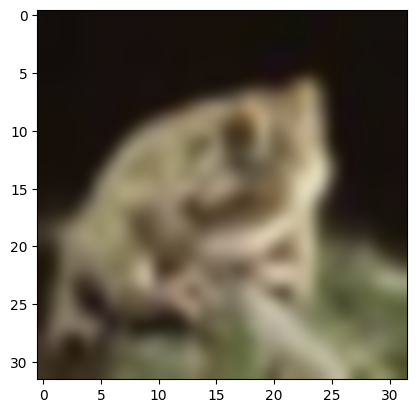

In [ ]:
print(X_train_full.shape)

plt.imshow(X_train[1], cmap='binary', interpolation='bicubic')

Los targets son numericos, del 0 al 9. Podemos guardar las etiquetas asi nos es mas facil analizar que tan bien o mal funciona nuestro modelo:

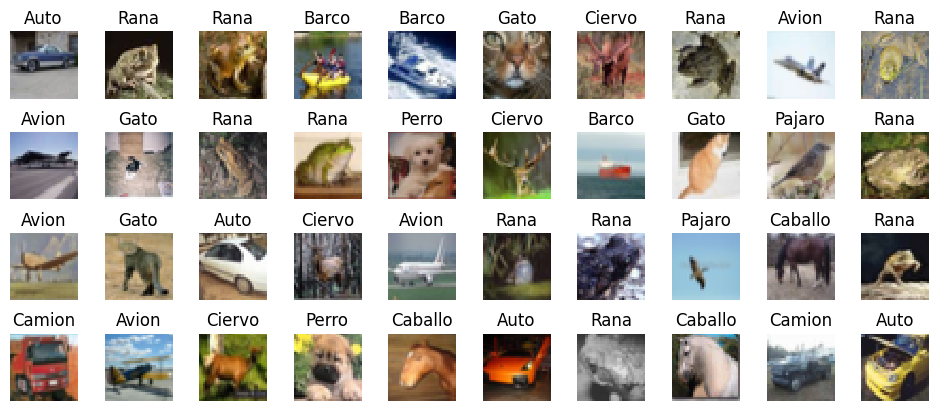

In [ ]:
class_names = ["Avion", "Auto", "Pajaro", "Gato","Ciervo", "Perro", "Rana", "Caballo", "Barco", "Camion"]

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index][0]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Repasemos los fundamentos de las CNNs

En muchos problemas, una DNN puede no leer apropiadamente los features, obteniendo una performance sub-optima. Muchas veces, esto sucede porque la DNN falla en reconocer estructuras locales o porque el numero de parametros necesario es tan grande que se vuelve propensa al overfitting. En estos casos, vale la pena intentar una CNN. En el resto del notebook tratare al input como imagenes compuestas por pixeles. Esto no implica que solo puedan utilizarse para imagenes sino que la representacion es multi-dimensional.


Las Redes Neuronales Convolucionales utilizan neuronas que no son sensibles a todo el conjunto de pixeles de la imagen. Esto permite captar mejor caracteristicas de los datos y a la vez bajar el numero de parametros involucrados.

Este principio es el que luego se aplica para construir los componentes fundamentales nuevos. Veamos como samplea el tipo de neurona que nos interesa.


Uno empieza [dibujando](https://www.youtube.com/watch?v=nyZw85q0kRQ) con una imagen de 3x4 (mi notacion sera siempre filas x columnas)
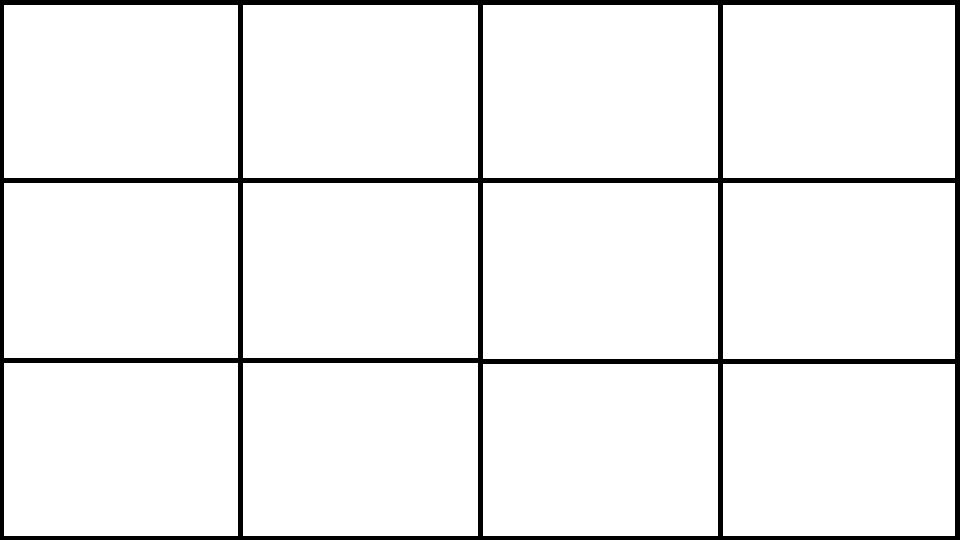

De esa imagen, vamos a seleccionar siempre de a un subconjunto (o ventana) que caracterizaremos por el numero de filas y de columnas consideradas [$f_h$,$f_w$] donde h viene de altura _height_ y w de anchura _width_.

Para nuestro ejemplo, podemos tomar ventanas de [2,2]. La primera de esas ventanas se ve en esta imagen:

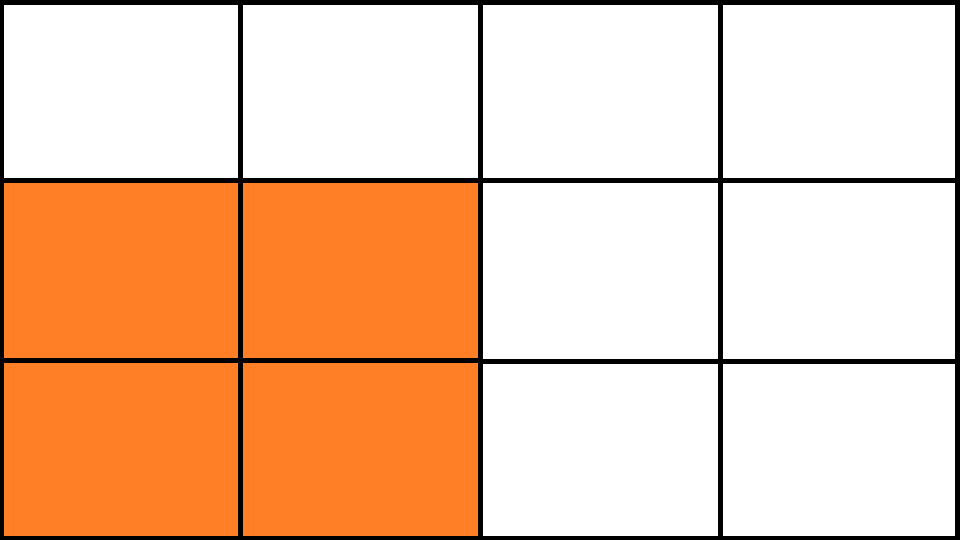

Una vez elegida la ventana, hay que elegir la superposicion entre ventanas. Esto se establece determinando la separacion en filas y en columnas entre ventanas. A estos dos parametros se los llama _stride height_ y _stride width_ [$s_h$,$s_w$], Se los toma de a uno a la vez.

Por ejemplo, tomando [2,2], obtenemos la segunda ventana en la direccion de las columnas facilmente.

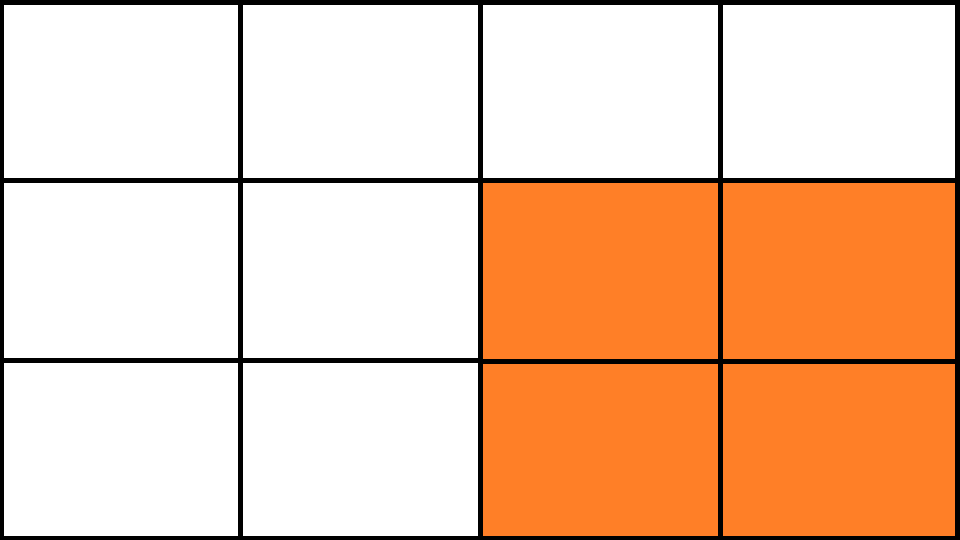

En la direccion de las filas sin embargo, tenemos un problema. Debido a $s_h$,$f_h$, la segunda ventana parece incompleta pero tambien hay datos no utilizados antes (esto no hubiese pasado si tomabamos por ejemplo $f_h = 2$, $s_h = 1$).

Frente a esto, tenemos dos opciones de "padding". En una, que sera "VALID" en tensorflow, simplemente no consideramos los datos que quedan afuera.

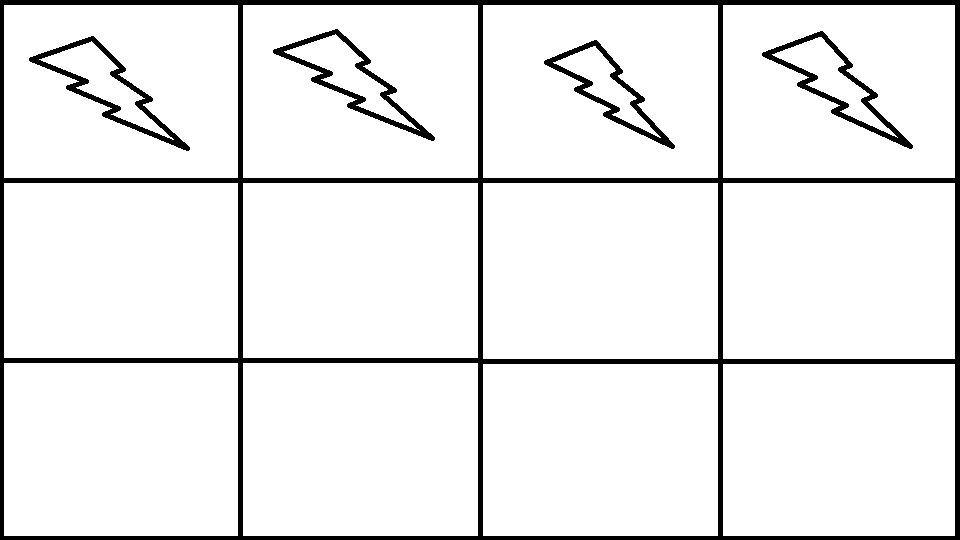

En la otra, llamada "SAME", ampliamos la imagen con ceros hasta que tenga el tamaño adecuado (en particular sera de shape $([H/s_h],[W/s_w])$) donde $[.]$ es la parte entera). La imagen en si no es representativo de como lo llenaria de ceros TensorFlow.

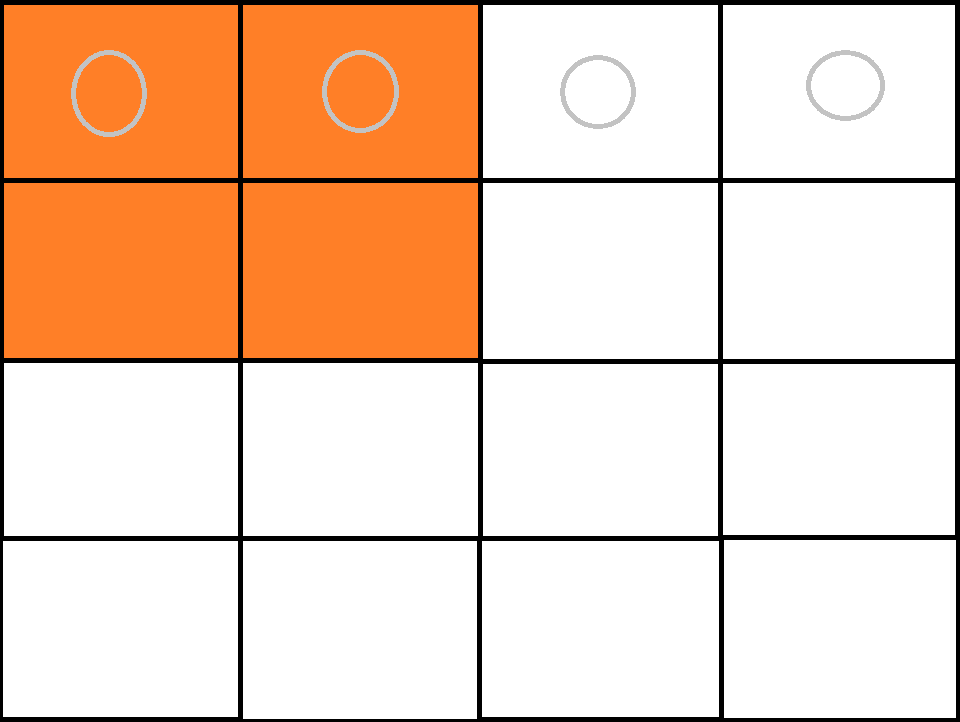


Finalmente, tras samplear con padding="SAME" uno obtiene la siguiente imagen:

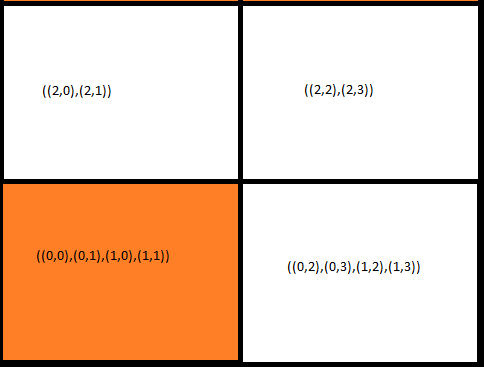


En particular, este tipo de sampleo se implementa en dos ladrillos basicos que agregan las CNNs.
* Los filtros y como estos definen capas convolucionales (Convolutional Layers).
* La capa de pooling (Pooling Layer).

### Filtros y Capa Convolucional

Un filtro clásico es una ventana que posee 0s y 1s en determinados pixeles. Una capa que consiste en un filtro que se mueve por toda la imagen se llama _feature map_. Los dos filtros "base" son los verticales y horizontales.

Esto lo preparo para aplicar el filtro

In [ ]:
images = X_train[0]
height, width, channels = images.shape

Estos son los dos filtros, pensando una ventana de (3,3).

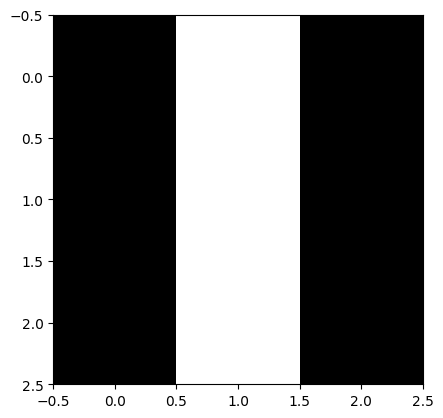

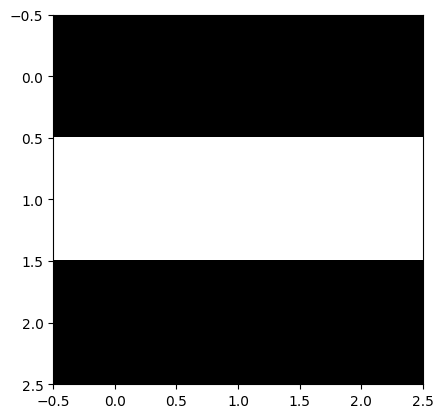

In [ ]:
filters = np.zeros(shape=(3, 3, channels, 2), dtype=np.float32)#presten atencion al shape
filters[:, 1, :, 0] = 1  # filtro vertical
filters[1, :, :, 1] = 1  # filtro horizontal
plt.imshow(filters[:, :, 0, 0], cmap="gray", interpolation="nearest")
plt.show()
plt.imshow(filters[:, :, 0, 1], cmap="gray", interpolation="nearest")
plt.show()

Y aplicandolos...  (tomo un codigo del Geron, luego vamos a hacer todo con API Funcional)


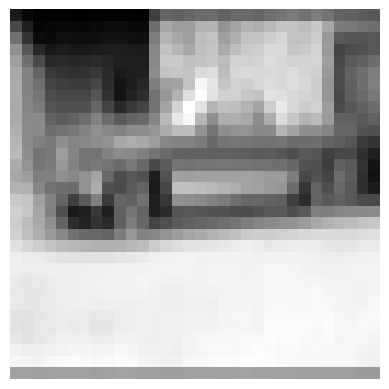

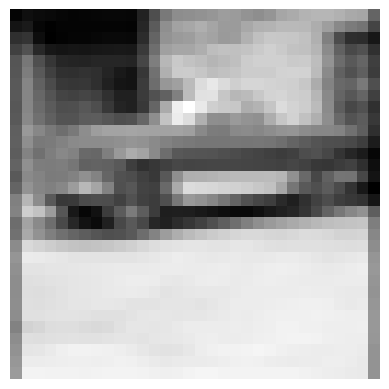

In [ ]:
outputs = tf.nn.conv2d(images.reshape(1,height,width,channels), filters, strides=1, padding="SAME")
plt.imshow(outputs[0, :, :, 0], cmap="gray") # Aplico el primer filtro
plt.axis("off") # Not shown in the book
plt.show()
plt.imshow(outputs[0, :, :, 1], cmap="gray") # Aplico el segundo filtro
plt.axis("off") # Not shown in the book
plt.show()

In [ ]:
outputs.shape

TensorShape([1, 32, 32, 2])

**Importante:**

Algo que se evidencia aca es que si bien el input es de shape (1,32,32,3), el output tiene shape (1,32,32,2). Esto es porque los 3 canales originales (RGB) se combinan en cada filtro. En el output los 2 canales corresponden a los dos filtros aplicados.

In [ ]:
print(outputs.shape)

(1, 32, 32, 2)


Uno puede pensar que cada Capa Convolucional es una superposicion de filtros, cada uno con un grupo de coeficientes distinto, incluido el bias.

Esto viene incorporado en Keras como

In [ ]:
keras.layers.Conv2D?

Los argumentos que nos interesan hoy son:

- filters: # de filtros de la capa
- kernel_size: Entero o array detallando la ventana utiliza.
- strides: entero o array de strides.
- padding: "valid" o "same"
- data_format: channels_last (default) o channels_first.
- activation: funcion de activacion si se desea.
- use_bias: Boleano, agrega o no un bias.


El input de una Conv2D tiene (por defecto) shape (batch_size, rows, cols, channels) mientras que el ouput (obtenido como activation(conv2d(inputs, kernel) + bias)) tendra shape (batch_size, new_rows, new_cols, filters). Los pesos de la capa tendran dimension ($f_{h},f_{w},f_{n'}, f_{n}$) donde $f_{n'}$ es el numero de canales en el input y $f_{n}$ el numero de filtros de la capa. El bias de la capa es un vector de dimension $f_{n}$.

Un par de precisiones:

*   Cada filtro tiene su propio set de coeficientes, pero tiene el mismo shape.
*   La neurona en la posicion [i,j] de cada filtro tiene el mismo campo receptivo.
*   Cada filtro ve todos los filtros de la capa anterior.



### Pooling

Las capas convolucionales pueden consumir mucha memoria debido al numero de parametros involucrados al hacer back-propagation. Ademas, pueden ser propensas al overfitting. Una tecnica para reducir la cantidad de parametros es la de subsamplear mediante el Pooling.

La capa de Pooling achica la imagen sampleando de la misma manera que la capa convolucional. Sin embargo, no tiene parametros sino que tiene una de dos estrategias:

*   Elige el mayor elemento de la ventana (max_pooling).
*   Toma el promedio de la ventana (average_pooling).

Otro beneficio del Pooling es que al tomar un "campo medio" de la imagen, agrega una ligera simetria de traslacion que mejora la generalizacion de la CNN.


In [ ]:
keras.layers.MaxPooling2D?

In [ ]:
keras.layers.AveragePooling2D?

- pool_size: entero o array, shape de la ventana.
- strides: entero, array o None (en cuyo caso defaultea a pool_size).
- padding: "valid" o "same".
data_format: lo mismo que antes

### Composicion basica de una CNN

Generalmente las CNNs tienen como ingredientes basicos los siguientes pasos:


1.   Combinacion de capas convolucionales + capas de Pooling
2.   Una DNN conectada al paso anterior a traves Flatten().
3.   Una funcion de perdida sobre el conjunto.

De esta manera, el paso 1. procesa la imagen y la transforma en un vector de features de los que una DNN puede aprender mucho mas facilmente que si leyese la imagen sin procesar.


## Si hay tiempo... Preprocesado

Siempre es inteligente preprocesar las imagenes, en particular si el dataset es "chico", para mejorar la performance de la CNN. Un desafio para este preprocesado es que, debido a la cantidad de datasets, no es conveniente hacerlo como un paso aparte de las CNNs.

 Por suerte, keras nos da una mano con la Clase ImageDataGenerator que nos permite preprocesar las imagenes en tiempo real.

In [ ]:
keras.preprocessing.image.ImageDataGenerator?

Este nos ofrece muchisimos argumentos:

- featurewise_center: Booleano que centra los datos alrededor de la medicion promedio en cada feature (o pixel).
- samplewise_center: Booleano que fija la media de una medicion en cero.
- featurewise_std_normalization: Booleano que escalea a cada feature por la varianza en el dataset.
- samplewise_std_normalization: Booleano qie escalea a la medicion para que tenga varianza 1.
- zca_whitening: Boolean. Aplicar o no ZCA whitening.
- zca_epsilon: Aplica ZCA whitening. El default es 1e-6.
- rotation_range: Entero que delimita el rango de las rotaciones al azar (0 a 180).
- width_shift_range: fraccion del ancho que se puede trasladar al azar horizontalmente.
- height_shift_range: fraccion de la altura que se puede trasladar al azar verticalmente.
- brightness_range: Rango de shifteo de brillo.
- shear_range: Rango de shear al azar (el angulo se mide en grados en sentido contrario a las agujas del reloj). Se refleja en intensidad de angulo de corte.
- zoom_range: Rango de zoom al azar.
- channel_shift_range: Rango de cambios al azar de canal.
- fill_mode: {"constant", "nearest", "reflect" or "wrap"}. El default es 'nearest'. Forma de rellenar imagenes para llegar a determinado shape.
- cval: Valor de relleno si se elige fill_mode = "constant".
- horizontal_flip: Booleano: invierte horizontalmente al azar.
- vertical_flip: Booleano: invierte verticalmente al azar.
- rescale: rescaleo de todos los inputs. Por defecto es None (0 es equivalente a None).
- preprocessing_function: funcion de preprocesado aplicada a cada imagen luego de cambiarle el tamanio y las otras aumentaciones.
- data_format: formato de datos.
- validation_split: fraccion reservada para validacion.
- dtype: el dtype de los arrays generados.

Y se utiliza de la siguiente manera:

In [ ]:
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(X_train)

Si lo quiero utilizar en mi fitteo, reemplazando mi model.fit por

In [ ]:
'''

model.fit_generator(datagen.flow(X_train, y_train,batch_size=batch_size), epochs=epochs,validation_data=(X_valid, y_valid),)

'''

'\n\nmodel.fit_generator(datagen.flow(X_train, y_train,batch_size=batch_size), epochs=epochs,validation_data=(X_valid, y_valid),)\n\n'

## Definamos el modelo con la API Funcional

La API funcional funciona definiendo Layers y utilizandolo como si fueran "funciones" que se aplican a los outputs de otros Layers. Keras irá rastreando estas conecciones, y luego generará un modelo entre el Layer de Inputs, y el de Outputs.

En particular, yo voy a replicar el modelo de Keras

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
X_train.shape[1:]

(32, 32, 3)

In [ ]:
input_ = keras.layers.Input(shape=(X_train.shape[1:])) #En este caso es necesario definir el Layer de Inputs
conv1 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(input_)
conv2 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3),  padding='valid',activation='relu')(conv1)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
dropout1 = keras.layers.Dropout(0.25)(pool1)
flatten = keras.layers.Flatten()(dropout1)
hidden1 = keras.layers.Dense(512, activation="relu")(flatten)
dropout2 = keras.layers.Dropout(0.5)(hidden1)
output = keras.layers.Dense(10, activation="softmax")(dropout2)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               368691

In [ ]:
9*32*3+32

896

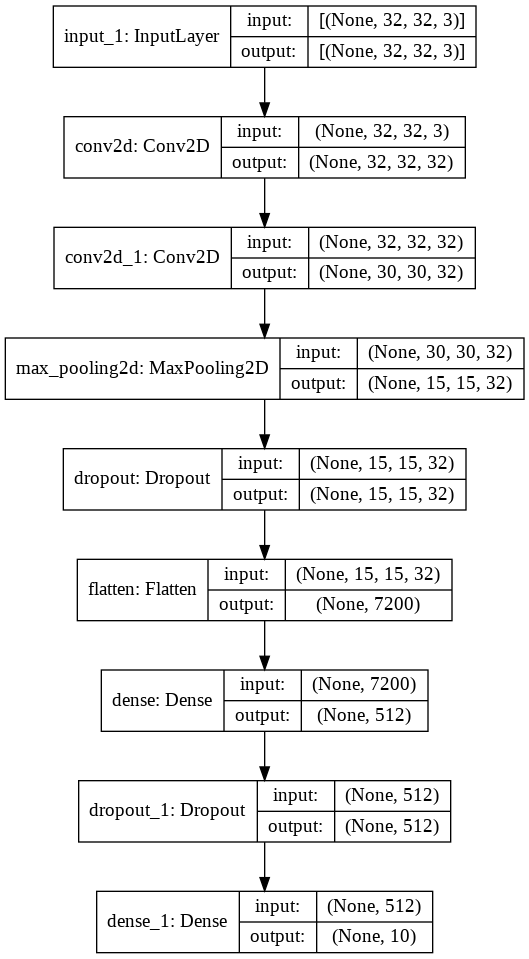

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

## Compilar y visualizar

Una vez que hemos definido nuestro modelo, es necesario que lo "compilemos", entonces Keras creará el gráfico computacional en TensorFlow de acuerdo a como lo hemos definido.

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
early_stopping_cb=keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

Podemos acceder a los diferentes Layers, mediante el atributo ``.layers``

In [ ]:
model.layers

Un buen desafio aca es interpretar los shapes y ver que estan bien.

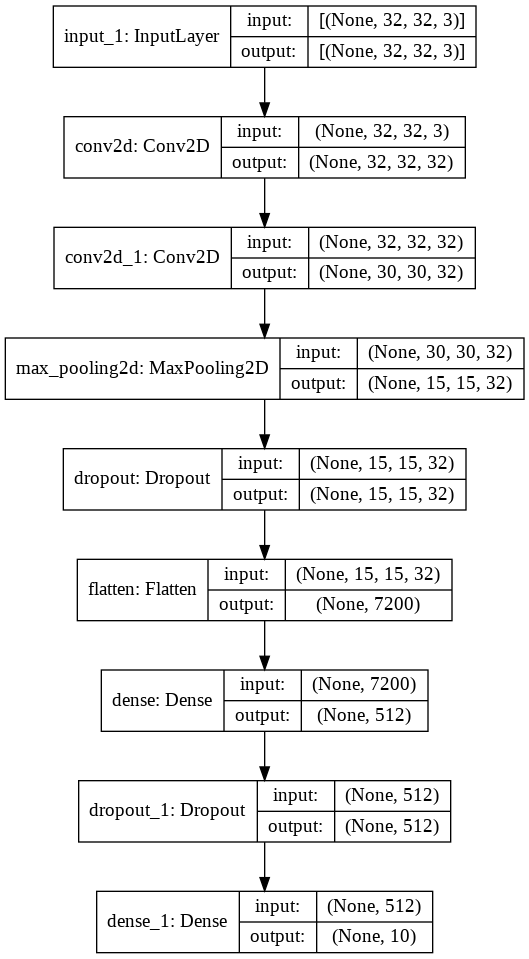

In [ ]:
keras.utils.plot_model(model, "my_cifar_cnn.png", show_shapes=True)

## Entrenar

Entrenar es tan facil como hacer un ``.fit``, donde podemos especificar muchas cosas como épocas, datos de validación (que evaluará al final de cada época), métricas, etc.

El método devuelve un objeto de Historia, con toda la información del entrenamiento (en forma de diccionarios), que podremos utilizar para analizar el modelo.

In [ ]:
history = model.fit(X_train, y_train[:,0], epochs=20,batch_size=100,
                    validation_data=(X_valid, y_valid[:,0]),callbacks=[early_stopping_cb])

Epoch 1/20
214/400 [===============>..............] - ETA: 49s - loss: 2.2381 - accuracy: 0.1682

KeyboardInterrupt: ignored

Examinemos el diccionario de parámetros del fit:

In [ ]:
history.params

NameError: ignored

In [ ]:
history.history.keys()

NameError: ignored

Podemos usar el atributo "history" que nos da un diccionario, para plotear las métricas que usamos.

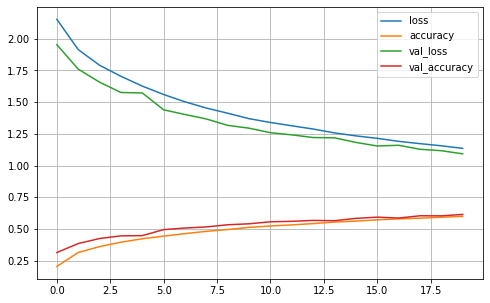

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.show()

## Evaluar y predecir

Evaluar en un conjunto de Test, o hacer predicciones, es sumamente fácil:

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.0976 - accuracy: 0.6145


[1.0976128578186035, 0.6144999861717224]

In [ ]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.05, 0.63, 0.02, 0.26, 0.03, 0.01, 0.  , 0.  ],
       [0.05, 0.51, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.42, 0.01],
       [0.24, 0.17, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.51, 0.07]],
      dtype=float32)

In [ ]:
y_pred = np.argmax(y_proba, axis=-1)
y_pred

array([9, 2, 1])

In [ ]:
np.array(class_names)[y_pred]

array(['Bota', 'Pullover', 'Pantalones'], dtype='<U10')

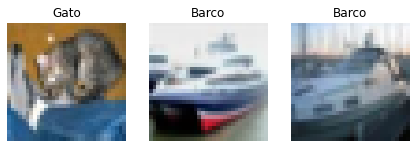

In [ ]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index][0]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Guardar y Cargar Modelos

Guardar modelos es tan sencillo como hacer

In [ ]:
model.save("my_keras_model.h5")

Que luego se puede cargar (por ejemplo en otra computadora, con otro script, para hacer predicciones) usando:

In [ ]:
model = keras.models.load_model("my_keras_model.h5")

También podemos guardar solamente los weights de los layers. Pero en este caso deberemos, antes de cargarlos, definir el mismo modelo que usamos y recien entonces cargar los weights

In [ ]:
model.save_weights("my_keras_weights.ckpt")

In [ ]:
model.load_weights("my_keras_weights.ckpt")